# ensemble

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize, StandardScaler
import glob
import tqdm
import torch

In [2]:
df = pd.read_csv("../input/shopee-product-matching/train_fold.csv")
df = df[df["fold"] == 0]
tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
df['target'] = df.label_group.map(tmp)


In [3]:
posting_id = df["posting_id"].values

In [4]:
def get_cosine_similarity(embeddings):

    CHUNK = 1024 * 2
    CTS = len(embeddings) // CHUNK
    if (len(embeddings)%CHUNK) != 0:
        CTS += 1
    distances = []
    
    with torch.no_grad():
        embeddings = normalize(embeddings)
        embeddings = torch.tensor(embeddings).cuda()

        for j in range( CTS ):
            a = j * CHUNK
            b = (j+1) * CHUNK
            b = min(b, len(embeddings))
            # print('chunk', a, 'to', b)

            # COSINE SIMILARITY DISTANCE
            cts = torch.matmul(embeddings, embeddings[a:b].T).T
            distances.append(cts.detach().cpu().numpy())
    
    return np.concatenate(distances)

In [5]:
def get_cv(df, similarity_matrix, threshold, posting_id, indices=None, pred_name="pred", min_n=2, mode="min"):
    preds = []
    for k in range(len(df)):
        if mode == "min": # euclid distance etc
            IDX = np.where(similarity_matrix[k, ] < threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[:min_n]
        if mode == "max": # cosine similarlity
            IDX = np.where(similarity_matrix[k, ] > threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[-min_n:]
            
        pred = posting_id[IDX]
        preds.append(pred)
    
    df[pred_name] = preds
    f1score, precision, recall = calc_cv(df, col_name=pred_name)
    return f1score, precision, recall

In [6]:
def calc_cv(df, col_name):
    tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
    df['target'] = df.label_group.map(tmp)
    df[f'f1_{col_name}'] = df.apply(get_f1(col_name),axis=1)
    df[f"precision_{col_name}"] = df.apply(get_precision(col_name), axis=1)
    df[f"recall_{col_name}"] = df.apply(get_recall(col_name), axis=1)
    return df[f"f1_{col_name}"].mean(), df[f"precision_{col_name}"].mean(), df[f"recall_{col_name}"].mean()

def get_f1(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

def get_precision(col):
    def precision_score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        if len(row[col]) == 0:
            return 0
        else:
            return n / len(row[col])
    return precision_score

def get_recall(col):
    def recall_score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return n / len(row.target)
    return recall_score

In [7]:
df_kiccho = pd.read_csv("kiccho-san/valid_df_0.csv")
df_kiccho = pd.merge(df, df_kiccho.reset_index()[["posting_id", "index"]])
kiccho_index = df_kiccho["index"].values

In [10]:
def get_best_epochs(model_path, early_stopping_round=3):
    file_len = len(glob.glob(f"{model_path}/indices_epoch*.npy"))
    return file_len - early_stopping_round - 1 # epoch は0はじまりなのでさらに1ひく


model_dict = {
   #  "bert": "../output/exp080/20210428030504", # CV: 0.862
    # "xlm_roberta": "../output/exp057/20210422123000", # CV: 0.855
    "distilbert": "../output/exp057_3/20210423001437", # CV: 0.857
    # "bert_transformer": "../output/exp068/20210425012131" # CV: 0.854,    
    # "bert_seresnet": "../output/exp019/20210415123913"
}

model_dist_dict = {}
    
for k, path in model_dict.items():
    best_epochs = get_best_epochs(path)
    
    model_dist_dict[k] = {
        "embeddings":  np.load(f"{path}/embeddings_epoch{best_epochs}.npy")
    }
    
    model_dist_dict[k]["cosine_similarity"] = get_cosine_similarity(model_dist_dict[k]["embeddings"])
model_dist_dict["bert"] = {
    "embeddings": np.load("../output/exp080/20210428030504/embeddings_all_epoch7.npy"),
    "cosine_similarity": get_cosine_similarity(np.load("../output/exp080/20210428030504/embeddings_all_epoch7.npy"))    
}
model_dist_dict["exp353"] = {
    "embeddings": np.load("kiccho-san/exp353/features_0_09.npy")[kiccho_index],
    "cosine_similarity": get_cosine_similarity(np.load("kiccho-san/exp353/features_0_09.npy")[kiccho_index])
}
model_dist_dict["exp359"] = {
    "embeddings": np.load("kiccho-san/exp359/features_0_08.npy")[kiccho_index],
    "cosine_similarity": get_cosine_similarity(np.load("kiccho-san/exp359/features_0_08.npy")[kiccho_index])
}
model_dist_dict["exp362"] = {
    "embeddings": np.load("kiccho-san/exp362/features_0_08.npy")[kiccho_index],
    "cosine_similarity": get_cosine_similarity(np.load("kiccho-san/exp362/features_0_08.npy")[kiccho_index])
}

In [11]:
embeddings = np.array([normalize(model_dist_dict[k]["embeddings"]) for k in model_dict.keys()])

In [12]:
np.concatenate(embeddings, axis=1).shape

(6839, 512)

In [13]:
similarity_concat = get_cosine_similarity(np.concatenate(embeddings, axis=1))
similarity_mean = get_cosine_similarity(embeddings.mean(axis=0))

In [14]:
def combine_predictions_any(row):
    x = np.concatenate(row[model_dist_dict.keys()].values)
    x = np.unique(x)
    return x

In [15]:
def combine_predictions_major(row):
    x = np.concatenate(row[model_dist_dict.keys()].values)
    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts > 1
    return x[ret_idx]

In [16]:
def combine_predictions_all(row):
    x = np.concatenate(row[model_dist_dict.keys()].values)

    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts == 3
    return x[ret_idx]

In [17]:
def combine_predictions_major2(row):
    x = np.concatenate(row[model_dist_dict.keys()].values)
    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts > 2
    return x[ret_idx]

In [18]:
def combine_predictions_major3(row):
    x = np.concatenate(row[model_dist_dict.keys()].values)
    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts > 3
    return x[ret_idx]

## get_cv(1件→2件むりやり)

In [19]:
def aggregate_distance(model_dist_dict, mode):
    ary = []
    
    for k, v in model_dist_dict.items():
        ary.append(model_dist_dict[k]["cosine_similarity"])
    
    ary = np.array(ary)
    
    if mode == "min":
        ary = ary.min(axis=0)
    if mode == "mean":
        ary = ary.mean(axis=0)
    if mode == "median":
        ary = np.median(ary, axis=0)
    if mode == "max":
        ary = ary.max(axis=0)

    return ary

In [20]:
df_result = []
for th in np.arange(0.35, 0.55, 0.01):
    print("=========================================================")
    print(f"THRESHOLD: {th}")
    for model_name in model_dist_dict.keys():
        f1score, precision, recall = get_cv(df, 
                                            model_dist_dict[model_name]["cosine_similarity"],
                                            th,
                                            posting_id,
                                            pred_name=model_name,
                                            min_n=2,
                                            mode="max")
        print(f"model={model_name} [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    df["pred"] = df.apply(combine_predictions_major, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    df["pred"] = df.apply(combine_predictions_major2, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR2>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

    df["pred"] = df.apply(combine_predictions_major3, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR3>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")


THRESHOLD: 0.35
model=distilbert [f1] 0.7569, [precision] 0.6782, [recall] 0.9615
model=bert [f1] 0.741, [precision] 0.6548, [recall] 0.9711
model=exp353 [f1] 0.8558, [precision] 0.8332, [recall] 0.9373
model=exp359 [f1] 0.8447, [precision] 0.8172, [recall] 0.9369
model=exp362 [f1] 0.8469, [precision] 0.8403, [recall] 0.9121
<<<ensemble_MAJOR>>>: [f1] 0.812, [precision] 0.7531, [recall] 0.9669
<<<ensemble_MAJOR2>>>: [f1] 0.8609, [precision] 0.834, [recall] 0.9521
<<<ensemble_MAJOR2>>>: [f1] 0.877, [precision] 0.878, [recall] 0.9316
THRESHOLD: 0.36
model=distilbert [f1] 0.7776, [precision] 0.7078, [recall] 0.9593
model=bert [f1] 0.7639, [precision] 0.686, [recall] 0.9687
model=exp353 [f1] 0.863, [precision] 0.8472, [recall] 0.9341
model=exp359 [f1] 0.8521, [precision] 0.8307, [recall] 0.9334
model=exp362 [f1] 0.8507, [precision] 0.8501, [recall] 0.9077
<<<ensemble_MAJOR>>>: [f1] 0.8237, [precision] 0.7698, [recall] 0.9653
<<<ensemble_MAJOR2>>>: [f1] 0.8671, [precision] 0.8459, [recall] 

model=exp362 [f1] 0.8551, [precision] 0.9203, [recall] 0.8457
<<<ensemble_MAJOR>>>: [f1] 0.8903, [precision] 0.8963, [recall] 0.9286
<<<ensemble_MAJOR2>>>: [f1] 0.8862, [precision] 0.9244, [recall] 0.8983
<<<ensemble_MAJOR2>>>: [f1] 0.8728, [precision] 0.9419, [recall] 0.8655
THRESHOLD: 0.4900000000000001
model=distilbert [f1] 0.8771, [precision] 0.8845, [recall] 0.9159
model=bert [f1] 0.8776, [precision] 0.8758, [recall] 0.9262
model=exp353 [f1] 0.8731, [precision] 0.9223, [recall] 0.8733
model=exp359 [f1] 0.8712, [precision] 0.916, [recall] 0.8757
model=exp362 [f1] 0.8527, [precision] 0.9227, [recall] 0.8402
<<<ensemble_MAJOR>>>: [f1] 0.8918, [precision] 0.9024, [recall] 0.9248
<<<ensemble_MAJOR2>>>: [f1] 0.8853, [precision] 0.9285, [recall] 0.8935
<<<ensemble_MAJOR2>>>: [f1] 0.8698, [precision] 0.9447, [recall] 0.8587
THRESHOLD: 0.5000000000000001
model=distilbert [f1] 0.8777, [precision] 0.8903, [recall] 0.9108
model=bert [f1] 0.8788, [precision] 0.882, [recall] 0.9216
model=exp353

In [21]:
df_result = []
for th in np.arange(0.5, 0.55, 0.01):
    print("=========================================================")
    print(f"THRESHOLD: {th}")
    for model_name in model_dist_dict.keys():
        f1score, precision, recall = get_cv(df, 
                                            model_dist_dict[model_name]["cosine_similarity"],
                                            th,
                                            posting_id,
                                            pred_name=model_name,
                                            min_n=2,
                                            mode="max")
        print(f"model={model_name} [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    df["pred"] = df.apply(combine_predictions_major, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    df["pred"] = df.apply(combine_predictions_major2, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR2>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

    df["pred"] = df.apply(combine_predictions_major3, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR2>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")


THRESHOLD: 0.5
model=distilbert [f1] 0.8777, [precision] 0.8903, [recall] 0.9108
model=bert [f1] 0.8788, [precision] 0.882, [recall] 0.9216
model=exp353 [f1] 0.8709, [precision] 0.9249, [recall] 0.8678
model=exp359 [f1] 0.8691, [precision] 0.918, [recall] 0.8709
model=exp362 [f1] 0.8499, [precision] 0.9254, [recall] 0.8336
<<<ensemble_MAJOR>>>: [f1] 0.8915, [precision] 0.9067, [recall] 0.9201
<<<ensemble_MAJOR2>>>: [f1] 0.8825, [precision] 0.9306, [recall] 0.8874
<<<ensemble_MAJOR2>>>: [f1] 0.8668, [precision] 0.9473, [recall] 0.8526
THRESHOLD: 0.51
model=distilbert [f1] 0.8786, [precision] 0.8962, [recall] 0.9062
model=bert [f1] 0.8811, [precision] 0.8895, [recall] 0.9176
model=exp353 [f1] 0.8687, [precision] 0.9273, [recall] 0.8625
model=exp359 [f1] 0.8664, [precision] 0.9205, [recall] 0.8642
model=exp362 [f1] 0.8471, [precision] 0.9277, [recall] 0.8273
<<<ensemble_MAJOR>>>: [f1] 0.8914, [precision] 0.9111, [recall] 0.9156
<<<ensemble_MAJOR2>>>: [f1] 0.8802, [precision] 0.9336, [reca

In [145]:
df_result = []
th = 0.5
print("=========================================================")
print(f"THRESHOLD: {th}")
for model_name in model_dist_dict.keys():
    f1score, precision, recall = get_cv(df, 
                                        model_dist_dict[model_name]["cosine_similarity"],
                                        th,
                                        posting_id,
                                        pred_name=model_name,
                                        min_n=2,
                                        mode="max")
    print(f"model={model_name} [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
df["pred"] = df.apply(combine_predictions_major, axis=1)
f1score, precision, recall = calc_cv(df, col_name="pred")
print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    

THRESHOLD: 0.5
model=bert [f1] 0.8771, [precision] 0.8827, [recall] 0.9182
model=distilbert [f1] 0.8777, [precision] 0.8903, [recall] 0.9108
model=exp347 [f1] 0.8752, [precision] 0.9218, [recall] 0.8775
model=exp342 [f1] 0.8767, [precision] 0.9136, [recall] 0.8865
<<<ensemble_MAJOR>>>: [f1] 0.8896, [precision] 0.9084, [recall] 0.9162


In [146]:
df["len_pred"] = [len(x) for x in df["pred"].values]
df["len_bert"] = [len(x) for x in df["bert"].values]

df["len_target"] = [len(x) for x in df["target"].values]

In [147]:
df.groupby("len_pred")["f1_pred"].describe()

count      mean       std       min       25%       50%       75%  \
len_pred                                                                       
1           77.0  0.574454  0.174613  0.038462  0.500000  0.666667  0.666667   
2         2560.0  0.937857  0.161988  0.083333  1.000000  1.000000  1.000000   
3         1032.0  0.904354  0.166825  0.133333  0.800000  1.000000  1.000000   
4          746.0  0.861104  0.177372  0.145455  0.666667  1.000000  1.000000   
5          487.0  0.869529  0.170568  0.153846  0.750000  1.000000  1.000000   
6          392.0  0.833290  0.181820  0.250000  0.727273  0.909091  1.000000   
7          223.0  0.810913  0.196356  0.142857  0.720779  0.833333  1.000000   
8          189.0  0.859509  0.185436  0.200000  0.769231  0.941176  1.000000   
9          202.0  0.884225  0.179158  0.181818  0.827922  1.000000  1.000000   
10         145.0  0.862148  0.193036  0.327869  0.823529  0.947368  1.000000   
11         127.0  0.823322  0.202083  0.307692  0.705882  0.880000  1.000000   
12          89.0  0.868659  0.177966  0.342857  0.736842  0.960000  1.000000   
13          49.0  0.821781  0.236711  0.266667  0.684211  0.960000  1.000000   
14          52.0  0.752917  0.156632  0.444444  0.655556  0.727273  0.933333   
15          52.0  0.922690  0.127790  0.571429  0.827703  1.000000  1.000000   
16          31.0  0.886542  0.176110  0.204082  0.820513  0.967742  1.000000   
17          53.0  0.929619  0.127535  0.500000  0.918919  1.000000  1.000000   
18           8.0  0.842308  0.135736  0.521739  0.837209  0.886538  0.923077   
19          14.0  0.830128  0.191161  0.347826  0.796554  0.914024  0.950000   
20          47.0  0.794172  0.206068  0.370370  0.811765  0.823529  0.975610   
21          21.0  0.814968  0.149037  0.384615  0.864865  0.864865  0.864865   
22           4.0  0.706773  0.298930  0.307692  0.562217  0.791615  0.936170   
23           8.0  0.561492  0.339874  0.160000  0.296296  0.458959  0.918155   
24           7.0  0.663144  0.255795  0.153846  0.640000  0.685714  0.791837   
25          20.0  0.808795  0.165398  0.148148  0.863636  0.863636  0.863636   
26           5.0  0.676054  0.146193  0.424242  0.675325  0.736842  0.771930   
27           4.0  0.732595  0.028297  0.692308  0.727871  0.739726  0.744450   
28          10.0  0.738678  0.141027  0.400000  0.708861  0.751260  0.773935   
29           8.0  0.819501  0.087173  0.725000  0.761250  0.786667  0.907578   
30          13.0  0.879852  0.084090  0.740741  0.819672  0.937500  0.937500   
31           7.0  0.894149  0.133028  0.625000  0.879520  0.968750  0.968750   
32          17.0  0.863310  0.204644  0.117647  0.825397  0.941176  0.969697   
33          26.0  0.881338  0.157077  0.216216  0.835443  0.892045  0.985075   
34          17.0  0.931671  0.070928  0.800000  0.861538  0.955224  1.000000   
35          21.0  0.812443  0.260039  0.205128  0.864198  0.878788  0.985915   
36          43.0  0.960608  0.061435  0.827586  0.895522  1.000000  1.000000   
37           4.0  0.866238  0.029247  0.840909  0.840909  0.866238  0.891566   
38          11.0  0.871305  0.022752  0.853933  0.853933  0.853933  0.889001   
39           4.0  0.917647  0.000000  0.917647  0.917647  0.917647  0.917647   
40           2.0  0.904677  0.036141  0.879121  0.891899  0.904677  0.917455   
41           3.0  0.891304  0.000000  0.891304  0.891304  0.891304  0.891304   
42           4.0  0.903226  0.000000  0.903226  0.903226  0.903226  0.903226   
43           2.0  0.914894  0.000000  0.914894  0.914894  0.914894  0.914894   
44           1.0  0.926316       NaN  0.926316  0.926316  0.926316  0.926316   
45           2.0  0.937500  0.000000  0.937500  0.937500  0.937500  0.937500   

               max  
len_pred            
1         0.666667  
2         1.000000  
3         1.000000  
4         1.000000  
5         1.000000  
6         1.000000  
7         1.000000  
8         1.000000  
9         1.000000  
10        1.000000 

In [148]:
df.groupby("len_bert")["f1_bert"].describe()

count      mean           std       min       25%       50%  \
len_bert                                                                 
2         2540.0  0.911567  1.929219e-01  0.037736  1.000000  1.000000   
3          993.0  0.908634  1.580792e-01  0.117647  0.800000  1.000000   
4          713.0  0.860266  1.715703e-01  0.181818  0.666667  1.000000   
5          508.0  0.854432  1.807486e-01  0.222222  0.750000  0.909091   
6          412.0  0.814221  1.941426e-01  0.111111  0.666667  0.883117   
7          270.0  0.798696  2.057899e-01  0.200000  0.675000  0.833333   
8          195.0  0.827008  2.030549e-01  0.200000  0.686275  0.933333   
9          214.0  0.843033  2.122372e-01  0.363636  0.800000  0.947368   
10         150.0  0.857886  1.951231e-01  0.333333  0.752976  0.947368   
11         138.0  0.806372  2.106507e-01  0.285714  0.676471  0.900000   
12          82.0  0.888620  1.861137e-01  0.342857  0.869565  0.960000   
13          56.0  0.792026  2.306020e-01  0.266667  0.631579  0.842365   
14          39.0  0.784330  1.620067e-01  0.250000  0.727273  0.782609   
15          63.0  0.878736  1.665081e-01  0.333333  0.789474  1.000000   
16          50.0  0.813476  2.407818e-01  0.086957  0.666667  0.967742   
17          46.0  0.942212  1.228869e-01  0.583333  0.953125  1.000000   
18          15.0  0.772083  1.957700e-01  0.363636  0.736398  0.850000   
19          21.0  0.796705  1.860758e-01  0.347826  0.730769  0.878049   
20          53.0  0.788298  2.193719e-01  0.181818  0.744186  0.823529   
21          20.0  0.808961  1.725406e-01  0.384615  0.864865  0.864865   
22           5.0  0.722695  3.113750e-01  0.166667  0.851064  0.851064   
23           4.0  0.842905  1.475225e-01  0.621622  0.842905  0.916667   
24          10.0  0.808817  2.005565e-01  0.285714  0.793658  0.897959   
25          27.0  0.726424  2.717763e-01  0.148148  0.754310  0.863636   
26           9.0  0.768950  6.272760e-02  0.675325  0.736842  0.771930   
27          12.0  0.675542  2.319639e-01  0.258065  0.622172  0.758621   
28           5.0  0.770595  1.407142e-01  0.557377  0.708861  0.808511   
29           9.0  0.735432  2.516271e-01  0.242424  0.725000  0.833333   
30          10.0  0.892127  6.416042e-02  0.786885  0.829040  0.929067   
31          14.0  0.898238  6.902956e-02  0.806452  0.815776  0.953846   
32          13.0  0.837603  2.031338e-01  0.222222  0.794872  0.861538   
33          18.0  0.941173  7.389323e-02  0.785714  0.879081  0.985075   
34           7.0  0.778205  2.601793e-01  0.210526  0.800000  0.850000   
35          12.0  0.951535  5.854418e-02  0.813953  0.933824  0.985915   
36          33.0  0.975133  5.574966e-02  0.827586  1.000000  1.000000   
37           2.0  0.863312  3.168206e-02  0.840909  0.852110  0.863312   
38           2.0  0.879347  3.594176e-02  0.853933  0.866640  0.879347   
39           5.0  0.896144  2.951000e-02  0.861111  0.866667  0.917647   
40          10.0  0.914658  2.508567e-02  0.876712  0.891899  0.930233   
41           5.0  0.932284  2.290824e-02  0.891304  0.942529  0.942529   
42          10.0  0.936877  2.425752e-02  0.903226  0.910374  0.954545   
43           9.0  0.949159  2.569926e-02  0.914894  0.914894  0.966292   
44          13.0  0.956275  2.537202e-02  0.926316  0.926316  0.977778   
45           2.0  0.937500  0.000000e+00  0.937500  0.937500  0.937500   
46           6.0  0.948454  1.216188e-16  0.948454  0.948454  0.948454   
47           6.0  0.959184  1.216188e-16  0.959184  0.959184  0.959184   
48           1.0  0.969697           NaN  0.969697  0.969697  0.969697   
49           2.0  0.980000  0.000000e+00  0.980000  0.980000  0.980000   

               75%       max  
len_bert                      
2         1.000000  1.000000  
3         1.000000  1.000000  
4         1.000000  1.000000  
5         1.000000  1.000000  
6         1.000000  1.000000  
7         1.000000  1.000000  
8         1.000000  1.000000  
9         1.000000  1.000000  


In [149]:
df.groupby("len_target")["f1_pred"].describe()

count      mean       std       min       25%       50%  \
len_target                                                             
2           2792.0  0.911415  0.177735  0.117647  1.000000  1.000000   
3           1068.0  0.897984  0.161035  0.285714  0.800000  1.000000   
4            688.0  0.879405  0.176139  0.205128  0.800000  1.000000   
5            470.0  0.896492  0.145827  0.285714  0.833333  1.000000   
6            336.0  0.847199  0.180285  0.222222  0.705882  0.909091   
7            217.0  0.848127  0.181433  0.142857  0.769231  0.923077   
8            192.0  0.866719  0.196161  0.153846  0.842105  0.937255   
9            162.0  0.935414  0.122880  0.363636  0.900000  1.000000   
10           100.0  0.931847  0.138380  0.181818  0.947368  1.000000   
11            77.0  0.902835  0.156530  0.153846  0.842105  1.000000   
12            96.0  0.815864  0.233888  0.133333  0.666667  0.932806   
13            78.0  0.824179  0.246548  0.142857  0.775974  0.960000   
14            42.0  0.645093  0.209614  0.125000  0.526316  0.727273   
15            60.0  0.974437  0.059293  0.571429  0.965517  1.000000   
16            48.0  0.833779  0.178171  0.315789  0.814236  0.864865   
17            34.0  1.000000  0.000000  1.000000  1.000000  1.000000   
18            18.0  0.302802  0.097397  0.105263  0.221429  0.285714   
19            19.0  0.876174  0.031992  0.863636  0.863636  0.863636   
20            20.0  0.937801  0.068358  0.787879  0.911411  0.946639   
21            21.0  0.869646  0.209046  0.090909  0.894737  0.950000   
22            22.0  0.686992  0.202990  0.083333  0.666667  0.729532   
23            23.0  0.626624  0.215251  0.230769  0.359914  0.756757   
25            25.0  0.792846  0.195169  0.148148  0.750000  0.844444   
31            31.0  0.801319  0.155165  0.062500  0.775795  0.843750   
33            33.0  0.887005  0.147953  0.204082  0.882353  0.925373   
34            34.0  0.949462  0.094534  0.488889  0.941587  0.985075   
36            36.0  0.996019  0.010797  0.941176  1.000000  1.000000   
46            46.0  0.740965  0.184594  0.296296  0.685714  0.820513   
51            51.0  0.736357  0.213395  0.038462  0.700584  0.813953   

                 75%       max  
len_target                      
2           1.000000  1.000000  
3           1.000000  1.000000  
4           1.000000  1.000000  
5           1.000000  1.000000  
6           1.000000  1.000000  
7           1.000000  1.000000  
8           1.000000  1.000000  
9           1.000000  1.000000  
10          1.000000  1.000000  
11          1.000000  1.000000  
12          1.000000  1.000000  
13          1.000000  1.000000  
14          0.823529  0.880000  
15          1.000000  1.000000  
16          0.941935  1.000000  
17          1.000000  1.000000  
18          0.363636  0.500000  
19          0.863636  0.974359  
20          1.000000  1.000000  
21          0.975610  0.975610  
22          0.805477  0.878049  
23          0.789474  0.820513  
25          0.897959  0.958333  
31          0.878788  0.909091  
33          0.955224  1.000000  
34          0.985075  1.000000  
36          1.000000  1.000000  
46          0.878049  0.930233  
51          0.866527  0.937500

In [150]:
df.groupby("len_target")["f1_bert"].describe()

count      mean       std       min       25%       50%  \
len_target                                                             
2           2792.0  0.886930  0.199568  0.148148  0.800000  1.000000   
3           1068.0  0.877543  0.184165  0.200000  0.800000  1.000000   
4            688.0  0.869270  0.180627  0.210526  0.800000  1.000000   
5            470.0  0.893515  0.154174  0.222222  0.833333  1.000000   
6            336.0  0.844011  0.179827  0.222222  0.705882  0.909091   
7            217.0  0.851098  0.184404  0.086957  0.769231  0.923077   
8            192.0  0.865174  0.186318  0.200000  0.769231  0.933333   
9            162.0  0.933025  0.119062  0.363636  0.900000  1.000000   
10           100.0  0.937065  0.134897  0.166667  0.947368  1.000000   
11            77.0  0.894361  0.158884  0.153846  0.846154  0.952381   
12            96.0  0.822553  0.238036  0.111111  0.719298  0.916084   
13            78.0  0.847695  0.230901  0.266667  0.842391  0.960000   
14            42.0  0.669879  0.201303  0.250000  0.544737  0.738636   
15            60.0  0.976168  0.052015  0.636364  0.967186  1.000000   
16            48.0  0.832420  0.190097  0.315789  0.814815  0.864865   
17            34.0  1.000000  0.000000  1.000000  1.000000  1.000000   
18            18.0  0.331530  0.149299  0.100000  0.200000  0.285714   
19            19.0  0.854853  0.019112  0.808511  0.854040  0.863636   
20            20.0  0.966106  0.043740  0.888889  0.918919  0.987805   
21            21.0  0.882224  0.188351  0.173913  0.923077  0.950000   
22            22.0  0.771256  0.234275  0.083333  0.800000  0.850000   
23            23.0  0.635428  0.207347  0.160000  0.394397  0.756757   
25            25.0  0.839010  0.193915  0.148148  0.851064  0.897959   
31            31.0  0.688735  0.218721  0.117647  0.724138  0.771930   
33            33.0  0.830226  0.138540  0.390244  0.779661  0.870968   
34            34.0  0.928529  0.148715  0.162162  0.953846  0.969697   
36            36.0  0.993398  0.021141  0.875000  0.996479  1.000000   
46            46.0  0.897096  0.134120  0.296296  0.917647  0.942529   
51            51.0  0.840105  0.173436  0.037736  0.800000  0.903226   

                 75%       max  
len_target                      
2           1.000000  1.000000  
3           1.000000  1.000000  
4           1.000000  1.000000  
5           1.000000  1.000000  
6           1.000000  1.000000  
7           1.000000  1.000000  
8           1.000000  1.000000  
9           1.000000  1.000000  
10          1.000000  1.000000  
11          1.000000  1.000000  
12          1.000000  1.000000  
13          1.000000  1.000000  
14          0.823529  0.923077  
15          1.000000  1.000000  
16          1.000000  1.000000  
17          1.000000  1.000000  
18          0.468696  0.615385  
19          0.863636  0.883721  
20          1.000000  1.000000  
21          0.975610  0.975610  
22          0.878049  0.952381  
23          0.789474  0.800000  
25          0.920000  0.960000  
31          0.819672  0.861538  
33          0.925373  0.984615  
34          0.985075  1.000000  
36          1.000000  1.000000  
46          0.966292  0.977778  
51          0.948454  0.980000

In [151]:
df[df["len_target"] == 51].sort_values("f1_pred")

posting_id                                 image  \
34064   train_658862317  5e207c624ee4d3365b4b43beee1437f8.jpg   
34091  train_3366673512  f2195976cc6379e4eb07f62bad3bb667.jpg   
34081  train_2789820394  bd523b18dffe2ab684b6bb1ca65c1baa.jpg   
34054  train_2041937727  30305306349deae2aceeb8e28e981307.jpg   
34068  train_1913449144  66da58f62547696c906051deee5759a2.jpg   
34051   train_516663932  1d89e95c4de0a09d726e5068810628a3.jpg   
34072  train_4060693827  6e5e87b82b0b484f7739f83a0de654f5.jpg   
34070  train_3195325438  6dc12f93d9989b40937b1bcc477360e6.jpg   
34066  train_2708192355  600bb1bad88a448a9e57237c7347827b.jpg   
34082  train_4003658555  d038c83eb29422e3b4d91e2838db53d6.jpg   
34057   train_664339299  381070f92bff1a9e131802c093e06ca6.jpg   
34086   train_711042017  db0e7e5fe0acfed1e71b1614286c0207.jpg   
34069  train_1540761220  66e99216f4c3925a331d98f99493493c.jpg   
34060  train_2918032299  51e5fd87322482a6318142f09073b5d9.jpg   
34090   train_627475146  f2195976cc6379e4eb07f62bad3bb667.jpg   
34087  train_2146279151  dbb3acc284ca23cbcecac9c60d79cca9.jpg   
34080  train_3945800827  bc9392cb2e4b8e5a5dfa7407339faabd.jpg   
34048  train_2930186018  00d368b4331f37573f69d083f4437f0d.jpg   
34089   train_846192553  e88a894bf35cb286b8a773f28866a477.jpg   
34063  train_1086903685  5cd5f1866e4da043e5ba10a01343b5e3.jpg   
34053  train_3480877149  2eedfbe10ba240a1c1cf74aa49b0d7ac.jpg   
34047  train_4175229751  00b9f86046a30f68841671d510077cc6.jpg   
34046  train_3497907844  007be583a5a4edc3fc54b0779e141a9f.jpg   
34059  train_1591104350  3f41ffc681c3069c0b56eb06f394d803.jpg   
34094  train_4178955354  fabc156cb747154ec2e5b52b6017ceef.jpg   
34071   train_365461299  6dc12f93d9989b40937b1bcc477360e6.jpg   
34084  train_2497676427  d49513b5d5fc8fb90af0a251e36a4dfd.jpg   
34073  train_2664816648  7c9eb4103f42746482b1e42d0ab5b3e3.jpg   
34052  train_2677100375  1dae7c73bc6f88e8002fb597c01cecfa.jpg   
34077  train_1799291694  a32d8c72784a1a21d6ef4ebf6f55eef0.jpg   
34061  train_2531777612  583effbcdeffc968a2e69c7b3f0b67bc.jpg   
34058  train_1296711926  3d3f6a96bcf25d53ecae7618cafdac72.jpg   
34074  train_3332324456  90196ca21abe4701aca7716e89bf69f8.jpg   
34050  train_1354360830  1bfeae8d7713be68d785b8e2ff7dd93c.jpg   
34078  train_3178715139  a78588044af25c96e0b80c037dfee4bf.jpg   
34079  train_2230152472  bb6569171e12e1a9983545686df3e546.jpg   
34065  train_2123729460  5f892c31c46638bde54d370a0d37c08f.jpg   
34088  train_2813067780  dcf5dba5bfe1f44e3551230030f4c712.jpg   
34055  train_1699906038  315c5722ace57a8aba433ddd29f4d644.jpg   
34067  train_3454652975  648a47bb79a64970d6143c9968781938.jpg   
34085  train_1943472851  d4f369d8f66ab4ced04159cb08abd936.jpg   
34096  train_3668806308  ffdd054398884b04bdab9e41d30c7fb2.jpg   
34095   train_112182868  fcbfbdb596fd53607b8dc9de8f108365.jpg   
34056  train_3534764813  315c5722ace57a8aba433ddd29f4d644.jpg   
34076  train_3956550694  96900b9d2ed7d5ab30c004307ac12ac5.jpg   
34049   train_515008716  108d7bbca23a3650bcbc2a77857c5c5f.jpg   
34075  train_1850201761  917956ce6ddbad7088efc58c2bf2e33e.jpg   
34092  train_4199111972  f2195976cc6379e4eb07f62bad3bb667.jpg   
34062  train_3731734583  59d27a721a092768ed3d293470389050.jpg   
34083   train_240158006  d2c1da48122a409d2a555763872a95f4.jpg   
34093  train_2114123891  f73cc9f71340603e294bdc6d8fea74ea.jpg   

            image_phash                                              title  \
34064  c0f5b44fadf02a0d                                 Paket dosis tinggi   
34091  94447e4e4efbaa28  MY CREATE WHITENING SPRAY - MY CREATE BODY SPR...   
34081  8bf0b42db485ed85  IMAGES SPRAY PUTIH UV Sunscreen Moisturizing P...   
34054  ecca219f259e34d1  MY CREATE SPRAY PEMUTIH VIRAL TIKTOK LOTION KOREA   
34068  dbc6c831e4a58675                           Mycreate hydrating spray   
34051  ef4870b519e52731               ISOLATION WHITENING PROTECTION SPRAY   
34072  db1a3c3d3c1a60d5  [COD] 1KG MUAT 6PC READYSTOCK Maycreate Spray ...   
34070  9

In [152]:
import matplotlib.pyplot as plt
from PIL import Image

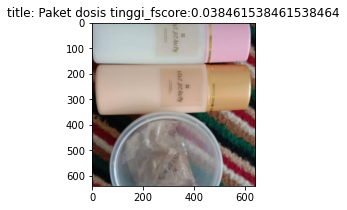

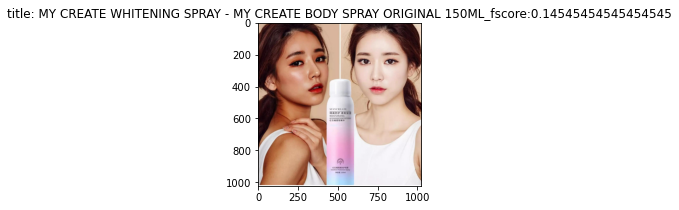

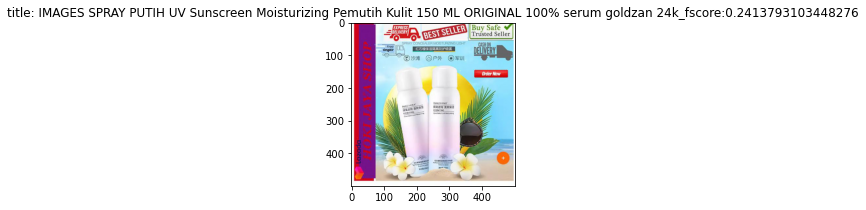

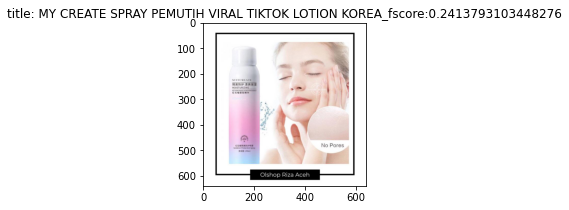

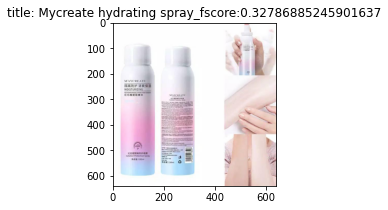

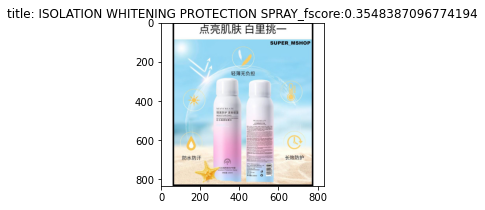

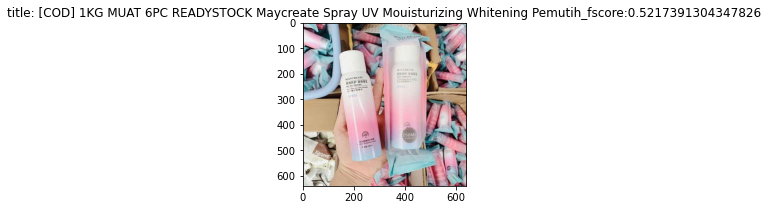

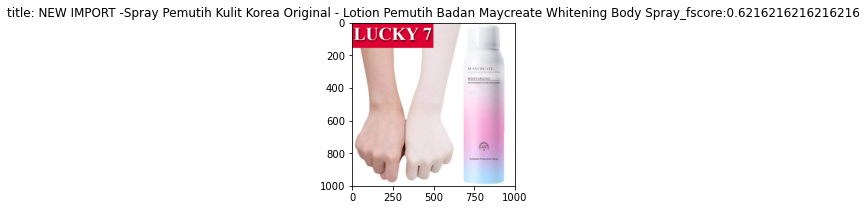

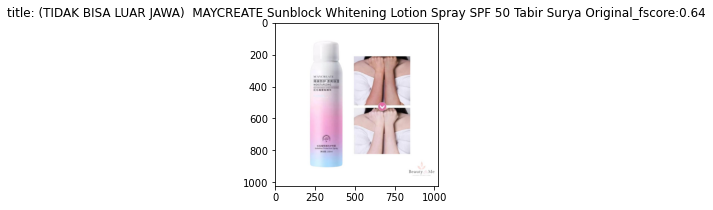

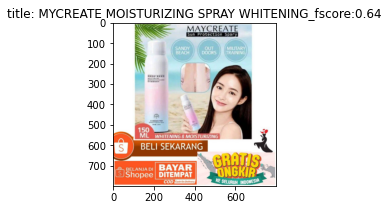

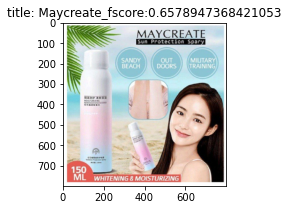

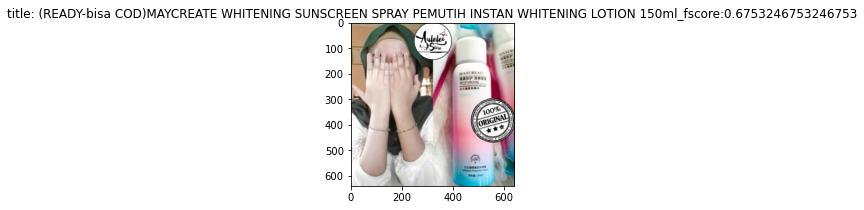

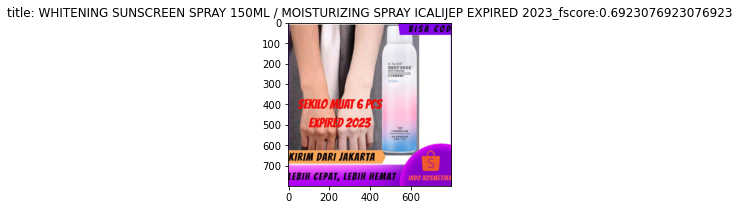

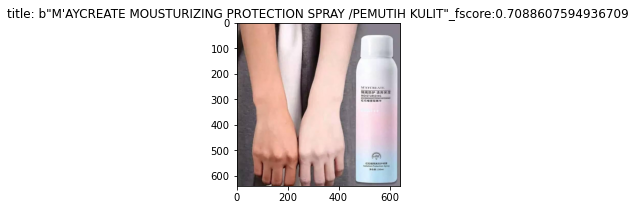

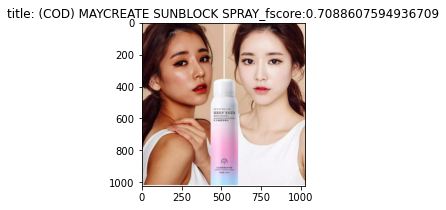

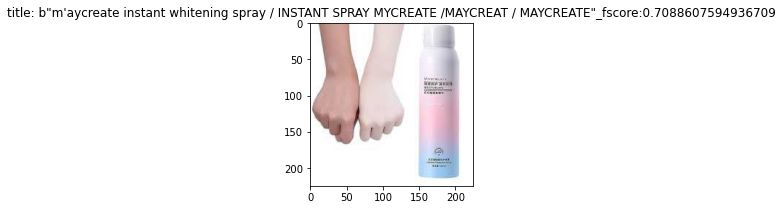

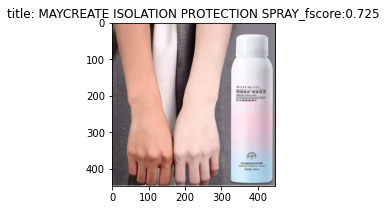

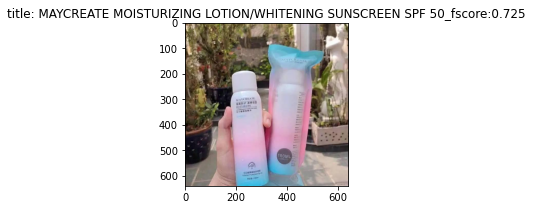

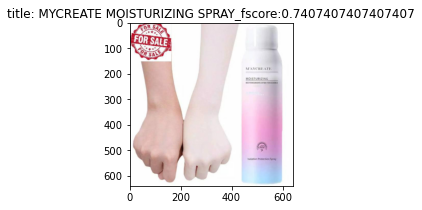

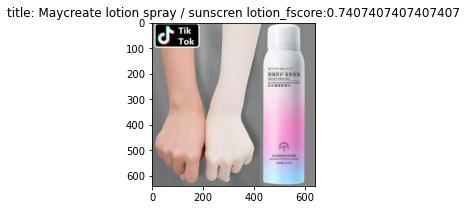

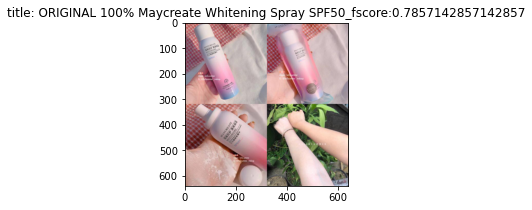

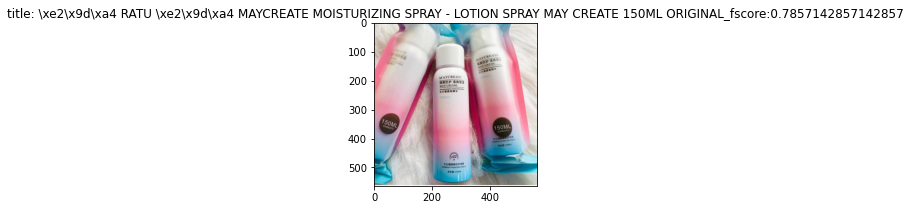

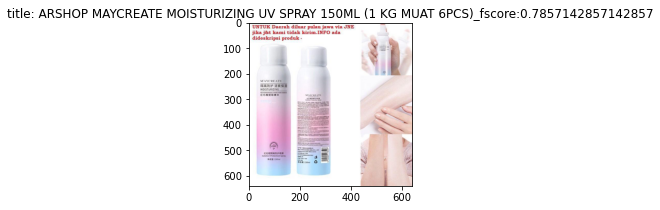

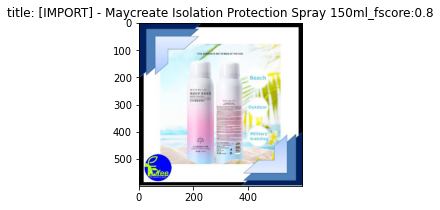

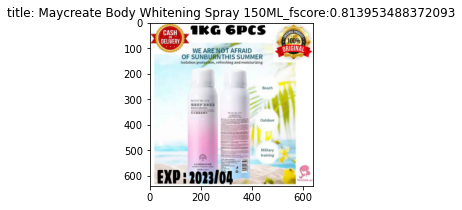

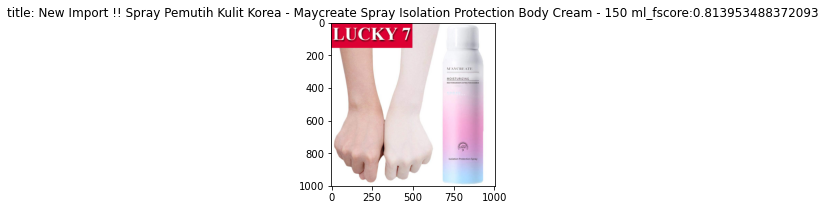

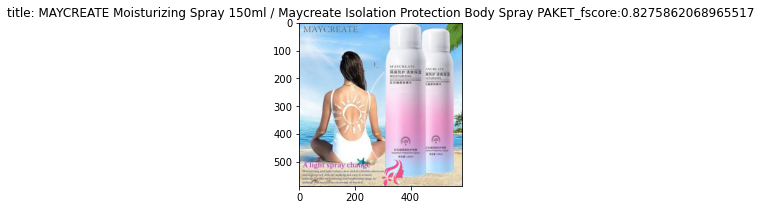

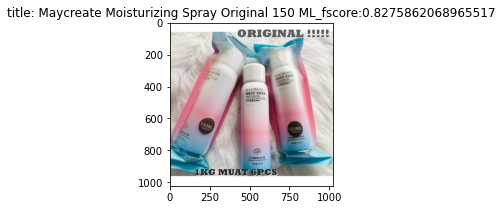

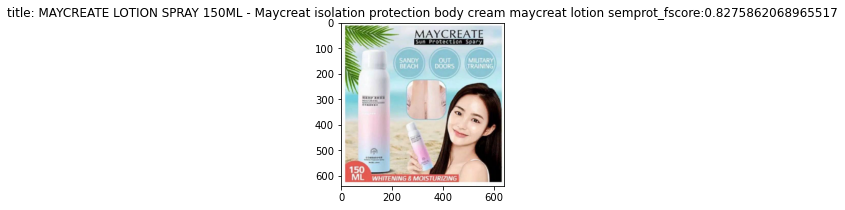

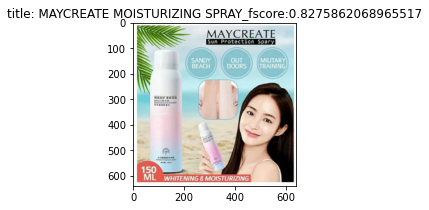

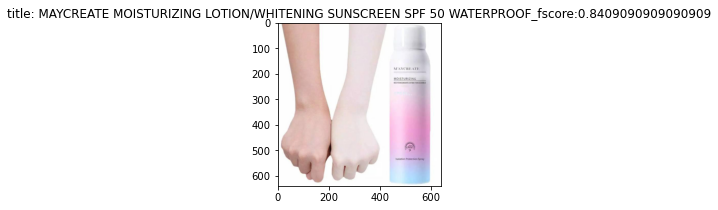

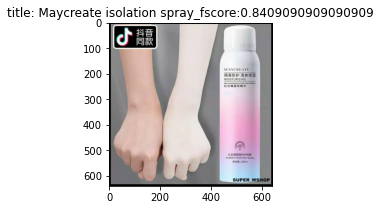

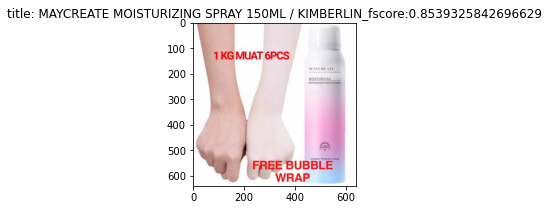

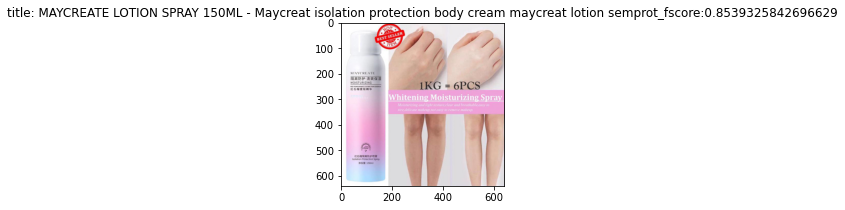

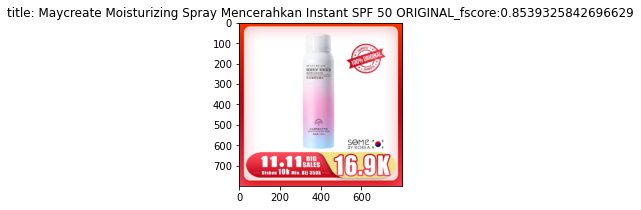

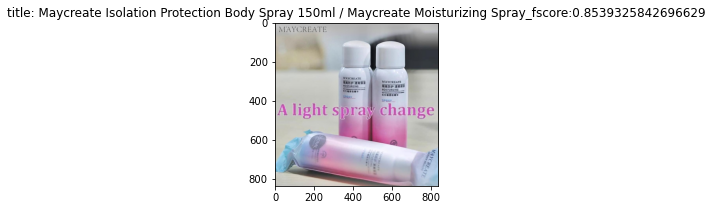

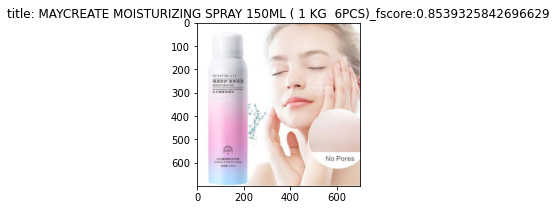

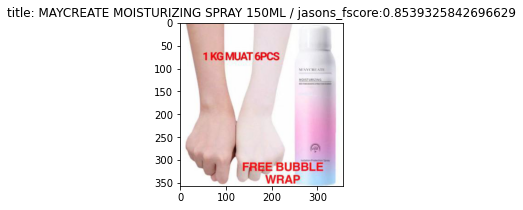

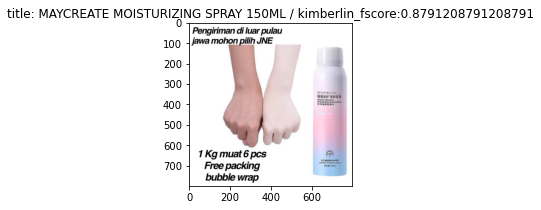

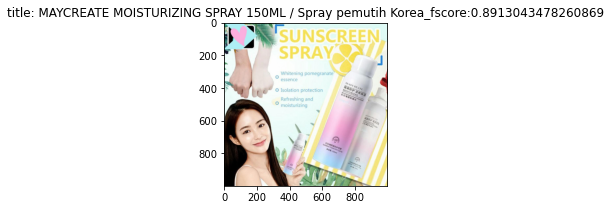

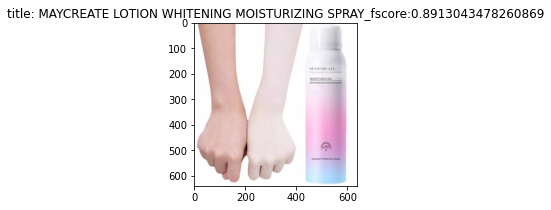

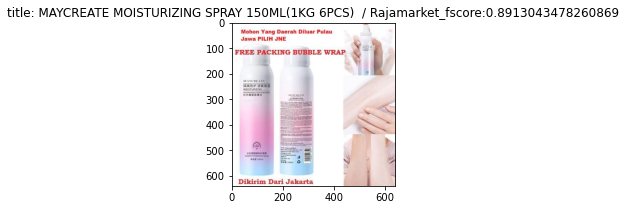

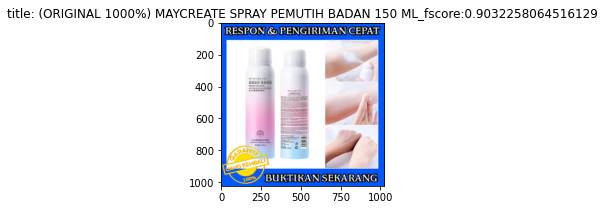

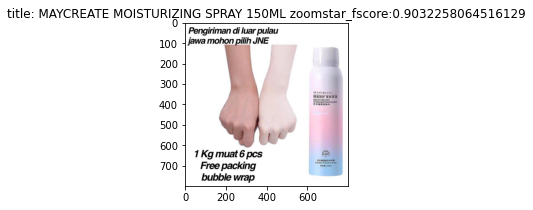

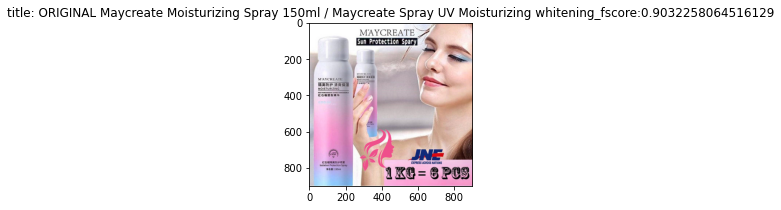

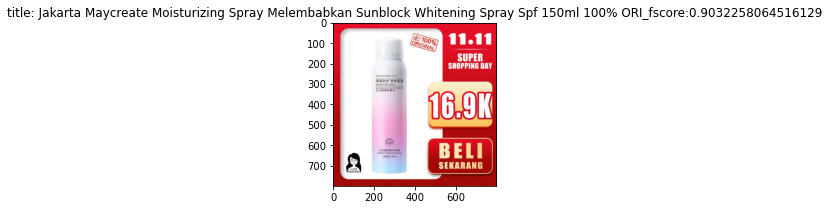

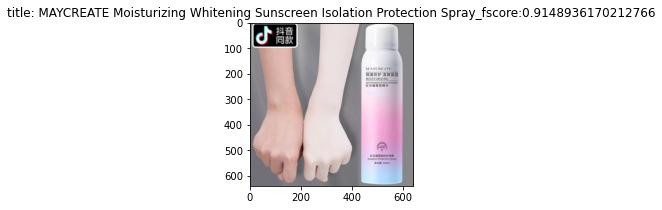

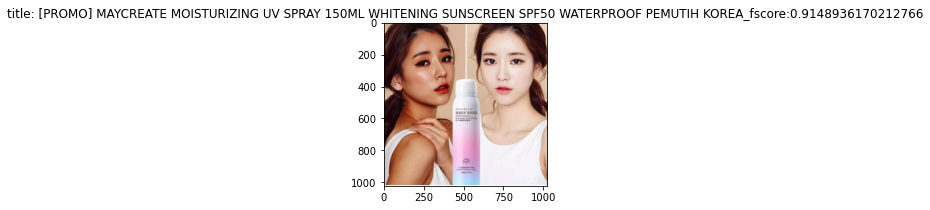

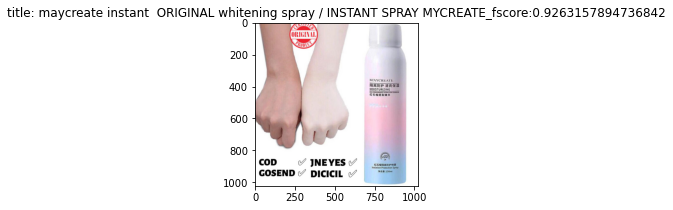

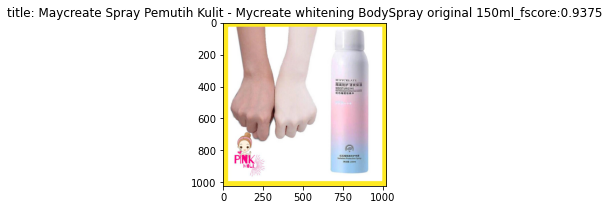

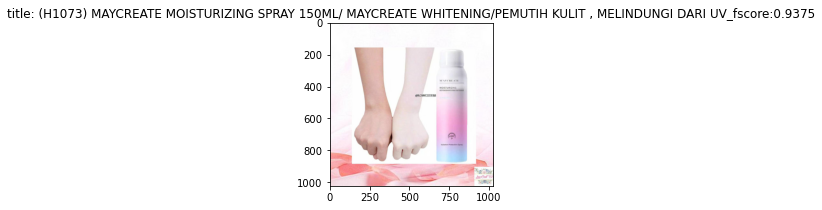

In [174]:

w_df = df[df["len_target"] == 51].sort_values("f1_pred")
for i in range(51):
    plt.figure(figsize=(3, 3))
    img = Image.open(f"../input/shopee-product-matching/train_images/{w_df['image'].values[i]}")
    plt.imshow(img)
    plt.title(f"title: {w_df['title'].values[i]}_fscore:{w_df['f1_pred'].values[i]}")
    plt.show()


In [175]:
w_df = df[["image_phash", "pred"]]
w_df.columns = ["image_phash", "pred_2"]

In [176]:
w_df = pd.merge(df, w_df)

In [177]:
def concat_pred(series):
    arys = []
    for ary in series.values:
        arys.extend(ary)
    return np.unique(arys)

In [178]:
df_postprocess = w_df.groupby("posting_id")["pred_2"].apply(concat_pred).reset_index()
df_postprocess.columns = ["posting_id", "pred_final"]

In [179]:
df_final = pd.merge(df, df_postprocess)

In [180]:
f1score, precision, recall = calc_cv(df_final, col_name="pred_final")
print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

<<<ensemble_MAJOR>>>: [f1] 0.8907, [precision] 0.9039, [recall] 0.9223


In [185]:
df_final["f1_pred_diff"] = df_final["f1_pred_final"] - df_final["f1_pred"]

In [191]:
df_final[df_final["f1_pred_diff"] != 0]["f1_pred_diff"].describe()

count    366.000000
mean       0.020784
std        0.161124
min       -0.619048
25%       -0.062027
50%        0.034446
75%        0.104886
max        0.813729
Name: f1_pred_diff, dtype: float64

In [195]:
df_final[df_final["f1_pred_diff"] != 0].groupby("image_phash")["f1_pred_diff"].describe().sort_values("mean")

count      mean       std       min       25%       50%  \
image_phash                                                                 
d2815e8c73cec339    1.0 -0.428571       NaN -0.428571 -0.428571 -0.428571   
e633998c99996666    2.0 -0.376190  0.343452 -0.619048 -0.497619 -0.376190   
e699996699669926    2.0 -0.333333  0.000000 -0.333333 -0.333333 -0.333333   
9fe0d01fe23b0f60    1.0 -0.333333       NaN -0.333333 -0.333333 -0.333333   
e897976a9e25c28c    1.0 -0.333333       NaN -0.333333 -0.333333 -0.333333   
...                 ...       ...       ...       ...       ...       ...   
fdabe0c2475c282d    4.0  0.273542  0.147146  0.126275  0.206807  0.245428   
898ed0f3ec8cb4e1    1.0  0.311688       NaN  0.311688  0.311688  0.311688   
8303e13b785c3d7c    8.0  0.312006  0.145432  0.107441  0.173855  0.361023   
acbeb7d0c8c2c9c4    4.0  0.361856  0.238376  0.157895  0.206140  0.298611   
94447e4e4efbaa28    3.0  0.369447  0.398312  0.044290  0.147306  0.250323   

                       75%       max  
image_phash                           
d2815e8c73cec339 -0.428571 -0.428571  
e633998c99996666 -0.254762 -0.133333  
e699996699669926 -0.333333 -0.333333  
9fe0d01fe23b0f60 -0.333333 -0.333333  
e897976a9e25c28c -0.333333 -0.333333  
...                    ...       ...  
fdabe0c2475c282d  0.312162  0.477037  
898ed0f3ec8cb4e1  0.311688  0.311688  
8303e13b785c3d7c  0.404028  0.507055  
acbeb7d0c8c2c9c4  0.454327  0.692308  
94447e4e4efbaa28  0.532026  0.813729  

[174 rows x 8 columns]

In [197]:
df_final[df_final["f1_pred_diff"] < 0].sort_values("f1_pred_diff")

posting_id                                 image  \
4432  train_1843989717  132a64f0151d2da67cb7c7b0e6314306.jpg   
1605  train_3688789080  77d4a468677b747b45e514ea7def1f15.jpg   
5821  train_3332372078  54c5a36d9017bd8bb959899818905bfc.jpg   
5820  train_2889620970  2a693eedc5aa71b4fd41bb551594ad23.jpg   
5823  train_1303536114  637f03a384557b4f784e78f13bfe6985.jpg   
...                ...                                   ...   
6563   train_633464770  21c5aa2babff1029f06bd89d01214f95.jpg   
4453  train_2493507457  dff188e20a03a2f795dae44739a07a9e.jpg   
5377  train_1358367394  451b108436f28c18b2dc8bf63b712c08.jpg   
6604   train_241440525  c739a327dbeca472089a5195e898cce4.jpg   
6549  train_1043384855  a5c474763f1e2ca528861c4a734d59ca.jpg   

           image_phash                                              title  \
4432  e633998c99996666  READY NIVEA Sparkling White Whitening Facial F...   
1605  d2815e8c73cec339         Citra hand body lotion bubuk mutiara 230ml   
5821  b6c8c835b1b66e0e  MUKENA ANAK DISNEY TSUM PINK TAS RANSEL/ GROSI...   
5820  b6c8c835b1b66e0e                     Mukena Disney Tsum Pink Ransel   
5823  b6c8c835b1b66e0e        MUKENA ANAK DISNEY TSUM PINK ( TAS RANSEL )   
...                ...                                                ...   
6563  ecb2c20d9cd0cb6d  Dot Bayi Ulir Peristaltic Reliable /Peristalti...   
4453  a3f27e812323d46d  FREE BUBBLE WRAP ! SLEEK Laundrt Detergent 120...   
5377  a22c8cf3d82f53e1  Dii Case Casing Tpu Softcase SILIKON Candy Mac...   
6604  ba96cc48cc63c56b  Anti crack soft jelly Samsung A3 2017,A5 2017,...   
6549  bbc5f41ec1381ce1   MUKENA ANAK KATUN FROZEN SISTER TAS SAJADAH PINK   

      label_group  phash_size  label_size  fold  \
4432   3625404959           2           4     0   
1605   2443520405           2           2     0   
5821   1662841908           8           9     0   
5820   1662841908           8           9     0   
5823   1662841908           8           9     0   
...           ...         ...         ...   ...   
6563   1306578136           5          23     0   
4453   3725072369           4           4     0   
5377    327189920           2           7     0   
6604   3717044186          14          25     0   
6549   1569494229           3          22     0   

                                                 target  \
4432  [train_1843989717, train_2518862130, train_325...   
1605               [train_3037005936, train_3688789080]   
5821  [train_1683455913, train_38222465, train_34576...   
5820  [train_1683455913, train_38222465, train_34576...   
5823  [train_1683455913, train_38222465, train_34576...   
...                                                 ...   
6563  [train_1568682908, train_2501253991, train_214...   
4453  [train_643717, train_2493507457, train_3943315...   
5377  [train_4085161467, train_2157486289, train_135...   
6604  [train_2743440279, train_377301035, train_3156...   
6549  [train_3078145839, train_2998559497, train_140...   

                                                   bert  ...  precision_pred  \
4432  [train_1843989717, train_2518862130, train_325...  ...        1.000000   
1605               [train_3037005936, train_3688789080]  ...        1.000000   
5821  [train_1683455913, train_38222465, train_34576...  ...        1.000000   
5820  [train_1683455913, train_38222465, train_34576...  ...        1.000000   
5823  [train_1683455913, train_38222465, train_34576...  ...        1.000000   
...                                                 ...  ...             ...   
6563  [train_1568682908, train_2501253991, train_214...  ...        1.000000   
4453  [train_2696502311, train_3037321658, train_643...  ...        0.181818   
5377  [train_4223515304, train_3498776127, train_329...  ...        0.142857   
6604  [train_719495468, train_2633571381, train_2743...  ...        1.000000   
6549  [train_1937934916, train_2739541152, train_307...  ...        0.875000   

      recall_pred  len_pred len_ber

In [201]:
w_df

posting_id                                 image  \
4432  train_1843989717  132a64f0151d2da67cb7c7b0e6314306.jpg   
6236  train_2520049290  de7fd4b1c1a145b01aa3d170ad610b0e.jpg   

           image_phash                                              title  \
4432  e633998c99996666  READY NIVEA Sparkling White Whitening Facial F...   
6236  e633998c99996666   Nivea Extra White Night Nourish Body Serum 180ml   

      label_group  phash_size  label_size  fold  \
4432   3625404959           2           4     0   
6236   1666545703           2          13     0   

                                                 target  \
4432  [train_1843989717, train_2518862130, train_325...   
6236  [train_3385602799, train_1673826544, train_553...   

                                                   bert  ...  precision_pred  \
4432  [train_1843989717, train_2518862130, train_325...  ...             1.0   
6236  [train_3385602799, train_1673826544, train_553...  ...             1.0   

      recall_pred  len_pred len_bert  len_target  \
4432          1.0         4        4           4   
6236          1.0        13       13          13   

                                             pred_final  f1_pred_final  \
4432  [train_1158252701, train_1673826544, train_172...       0.380952   
6236  [train_1158252701, train_1673826544, train_172...       0.866667   

     precision_pred_final  recall_pred_final  f1_pred_diff  
4432             0.235294                1.0     -0.619048  
6236             0.764706                1.0     -0.133333  

[2 rows x 37 columns]

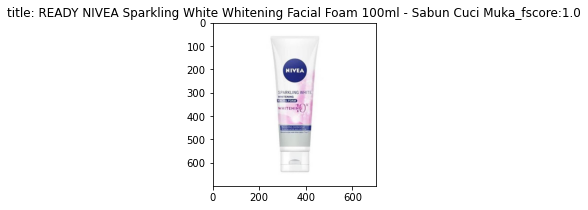

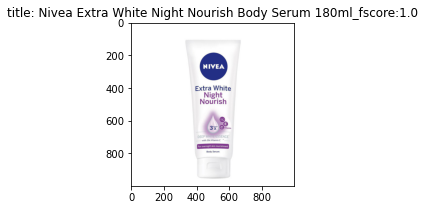

In [200]:

w_df = df_final[df_final["image_phash"] == "e633998c99996666"].sort_values("f1_pred")
for i in range(len(w_df)):
    plt.figure(figsize=(3, 3))
    img = Image.open(f"../input/shopee-product-matching/train_images/{w_df['image'].values[i]}")
    plt.imshow(img)
    plt.title(f"title: {w_df['title'].values[i]}_fscore:{w_df['f1_pred'].values[i]}")
    plt.show()


posting_id                                 image  \
1604  train_3037005936  121d1a1a248c32b1be0244bf7f0f0c0c.jpg   
1605  train_3688789080  77d4a468677b747b45e514ea7def1f15.jpg   

           image_phash                                            title  \
1604  d2815e8c73cec339  Citra Lotion Pearly White UV Hand & Body 230 ml   
1605  d2815e8c73cec339       Citra hand body lotion bubuk mutiara 230ml   

      label_group  phash_size  label_size  fold  \
1604   2443520405           2           2     0   
1605   2443520405           2           2     0   

                                    target  \
1604  [train_3037005936, train_3688789080]   
1605  [train_3037005936, train_3688789080]   

                                                   bert  ...  precision_pred  \
1604  [train_3037005936, train_3688789080, train_144...  ...             0.4   
1605               [train_3037005936, train_3688789080]  ...             1.0   

      recall_pred  len_pred len_bert  len_target  \
1604          1.0         5        7           2   
1605          1.0         2        2           2   

                                             pred_final  f1_pred_final  \
1604  [train_1305500108, train_2168993061, train_288...       0.571429   
1605  [train_1305500108, train_2168993061, train_288...       0.571429   

     precision_pred_final  recall_pred_final  f1_pred_diff  
1604                  0.4                1.0      0.000000  
1605                  0.4                1.0     -0.428571  

[2 rows x 37 columns]

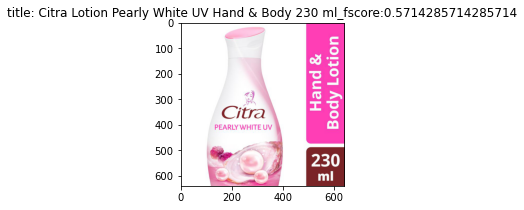

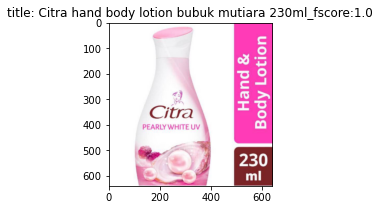

In [203]:

w_df = df_final[df_final["image_phash"] == "d2815e8c73cec339"].sort_values("f1_pred")
display(w_df)
for i in range(len(w_df)):
    plt.figure(figsize=(3, 3))
    img = Image.open(f"../input/shopee-product-matching/train_images/{w_df['image'].values[i]}")
    plt.imshow(img)
    plt.title(f"title: {w_df['title'].values[i]}_fscore:{w_df['f1_pred'].values[i]}")
    plt.show()


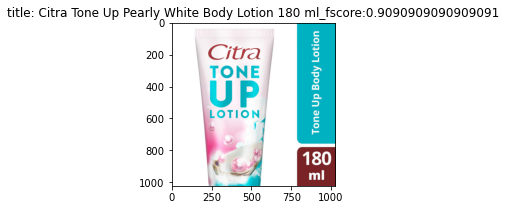

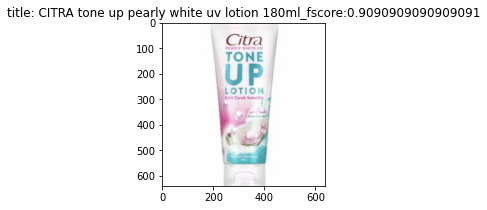

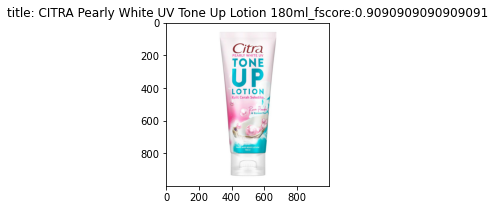

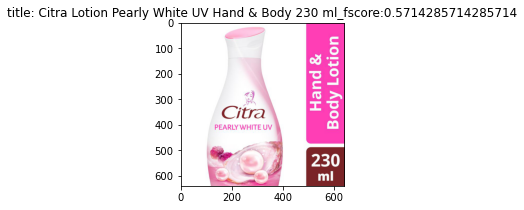

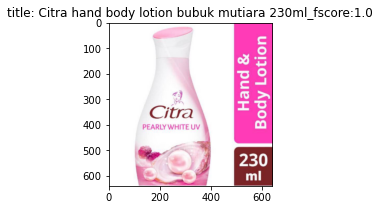

In [208]:

images = df_final[df_final["posting_id"] == "train_3037005936"]["pred"].iloc[0]
for image in images:
    w_df = df[df["posting_id"] == image]
    plt.figure(figsize=(3, 3))
    img = Image.open(f"../input/shopee-product-matching/train_images/{w_df['image'].values[i]}")
    plt.imshow(img)
    plt.title(f"title: {w_df['title'].values[i]}_fscore:{w_df['f1_pred'].values[i]}")
    plt.show()


In [182]:
df.groupby("len_target")["f1_pred"].describe()

count      mean       std       min       25%       50%  \
len_target                                                             
2           2792.0  0.911415  0.177735  0.117647  1.000000  1.000000   
3           1068.0  0.897984  0.161035  0.285714  0.800000  1.000000   
4            688.0  0.879405  0.176139  0.205128  0.800000  1.000000   
5            470.0  0.896492  0.145827  0.285714  0.833333  1.000000   
6            336.0  0.847199  0.180285  0.222222  0.705882  0.909091   
7            217.0  0.848127  0.181433  0.142857  0.769231  0.923077   
8            192.0  0.866719  0.196161  0.153846  0.842105  0.937255   
9            162.0  0.935414  0.122880  0.363636  0.900000  1.000000   
10           100.0  0.931847  0.138380  0.181818  0.947368  1.000000   
11            77.0  0.902835  0.156530  0.153846  0.842105  1.000000   
12            96.0  0.815864  0.233888  0.133333  0.666667  0.932806   
13            78.0  0.824179  0.246548  0.142857  0.775974  0.960000   
14            42.0  0.645093  0.209614  0.125000  0.526316  0.727273   
15            60.0  0.974437  0.059293  0.571429  0.965517  1.000000   
16            48.0  0.833779  0.178171  0.315789  0.814236  0.864865   
17            34.0  1.000000  0.000000  1.000000  1.000000  1.000000   
18            18.0  0.302802  0.097397  0.105263  0.221429  0.285714   
19            19.0  0.876174  0.031992  0.863636  0.863636  0.863636   
20            20.0  0.937801  0.068358  0.787879  0.911411  0.946639   
21            21.0  0.869646  0.209046  0.090909  0.894737  0.950000   
22            22.0  0.686992  0.202990  0.083333  0.666667  0.729532   
23            23.0  0.626624  0.215251  0.230769  0.359914  0.756757   
25            25.0  0.792846  0.195169  0.148148  0.750000  0.844444   
31            31.0  0.801319  0.155165  0.062500  0.775795  0.843750   
33            33.0  0.887005  0.147953  0.204082  0.882353  0.925373   
34            34.0  0.949462  0.094534  0.488889  0.941587  0.985075   
36            36.0  0.996019  0.010797  0.941176  1.000000  1.000000   
46            46.0  0.740965  0.184594  0.296296  0.685714  0.820513   
51            51.0  0.736357  0.213395  0.038462  0.700584  0.813953   

                 75%       max  
len_target                      
2           1.000000  1.000000  
3           1.000000  1.000000  
4           1.000000  1.000000  
5           1.000000  1.000000  
6           1.000000  1.000000  
7           1.000000  1.000000  
8           1.000000  1.000000  
9           1.000000  1.000000  
10          1.000000  1.000000  
11          1.000000  1.000000  
12          1.000000  1.000000  
13          1.000000  1.000000  
14          0.823529  0.880000  
15          1.000000  1.000000  
16          0.941935  1.000000  
17          1.000000  1.000000  
18          0.363636  0.500000  
19          0.863636  0.974359  
20          1.000000  1.000000  
21          0.975610  0.975610  
22          0.805477  0.878049  
23          0.789474  0.820513  
25          0.897959  0.958333  
31          0.878788  0.909091  
33          0.955224  1.000000  
34          0.985075  1.000000  
36          1.000000  1.000000  
46          0.878049  0.930233  
51          0.866527  0.937500

In [181]:
df_final.groupby("len_target")["f1_pred_final"].describe()

count      mean       std       min       25%       50%  \
len_target                                                             
2           2792.0  0.909695  0.178949  0.117647  1.000000  1.000000   
3           1068.0  0.897882  0.161996  0.285714  0.800000  1.000000   
4            688.0  0.876965  0.179976  0.205128  0.800000  1.000000   
5            470.0  0.897451  0.146436  0.285714  0.833333  1.000000   
6            336.0  0.846424  0.182624  0.222222  0.696078  0.909091   
7            217.0  0.852743  0.185049  0.133333  0.777778  0.923077   
8            192.0  0.868414  0.192672  0.153846  0.842105  0.941176   
9            162.0  0.927405  0.134813  0.363636  0.900000  1.000000   
10           100.0  0.935203  0.137888  0.181818  0.947368  1.000000   
11            77.0  0.924456  0.136282  0.153846  0.880000  1.000000   
12            96.0  0.826002  0.231726  0.133333  0.666667  0.956522   
13            78.0  0.838634  0.246208  0.142857  0.830303  0.960000   
14            42.0  0.653991  0.210568  0.125000  0.526316  0.727273   
15            60.0  0.972746  0.060215  0.571429  0.965517  1.000000   
16            48.0  0.833779  0.178171  0.315789  0.814236  0.864865   
17            34.0  1.000000  0.000000  1.000000  1.000000  1.000000   
18            18.0  0.317953  0.115684  0.105263  0.221429  0.285714   
19            19.0  0.870346  0.021466  0.863636  0.863636  0.863636   
20            20.0  0.985340  0.049879  0.787879  1.000000  1.000000   
21            21.0  0.882977  0.211541  0.090909  0.923077  0.950000   
22            22.0  0.767509  0.223406  0.083333  0.731707  0.878049   
23            23.0  0.627612  0.215838  0.230769  0.359914  0.756757   
25            25.0  0.800054  0.195609  0.148148  0.750000  0.905660   
31            31.0  0.804757  0.156417  0.062500  0.775795  0.843750   
33            33.0  0.888776  0.080202  0.666667  0.888889  0.909091   
34            34.0  0.951752  0.095028  0.488889  0.957809  0.985075   
36            36.0  0.998435  0.004489  0.985915  1.000000  1.000000   
46            46.0  0.829315  0.125034  0.327273  0.777368  0.864198   
51            51.0  0.772474  0.202957  0.038462  0.725000  0.840909   

                 75%       max  
len_target                      
2           1.000000  1.000000  
3           1.000000  1.000000  
4           1.000000  1.000000  
5           1.000000  1.000000  
6           1.000000  1.000000  
7           1.000000  1.000000  
8           1.000000  1.000000  
9           1.000000  1.000000  
10          1.000000  1.000000  
11          1.000000  1.000000  
12          1.000000  1.000000  
13          1.000000  1.000000  
14          0.823529  0.880000  
15          1.000000  1.000000  
16          0.941935  1.000000  
17          1.000000  1.000000  
18          0.363636  0.500000  
19          0.863636  0.950000  
20          1.000000  1.000000  
21          0.975610  0.975610  
22          0.888889  0.888889  
23          0.794737  0.820513  
25          0.905660  0.905660  
31          0.887155  0.909091  
33          0.925373  0.968750  
34          0.985075  1.000000  
36          1.000000  1.000000  
46          0.891566  0.930233  
51          0.903226  0.959184

In [223]:
df.iloc[7]

posting_id                                  train_4262738264
image                   46ec8e754707f5d16d7e75ff9ad607bc.jpg
image_phash                                 b3c80cdb0c724ef6
title                      Refill Kopi Nescafe Classic 100gr
label_group                                          9958453
phash_size                                                 1
label_size                                                 2
fold                                                       0
target                   [train_120583569, train_4262738264]
bert                     [train_120583569, train_4262738264]
f1_bert                                                    1
precision_bert                                             1
recall_bert                                                1
distilbert               [train_120583569, train_4262738264]
f1_distilbert                                              1
precision_distilbert                                       1
recall_distilbert       

In [224]:
df["title"].values[20:30]

array(['b"Kintakun Sprei D\'luxe - 120 x 200 (Extra Single) - Tiana"',
       'SPREI KINTAKUN DLUXE 120x200x20 CM MOTIF MEIKO - SCARLET - TIANA - CASEY',
       'SALLY TUNIK / atasan wanita',
       '[ Promo Cuci Gudang ] Sally tunik | S M L XL | Atasan muslim best seller',
       '11 IN 1 PRO RESISTANCE BAND SET FITNESS GYM STRETCHING PILATES YOGA',
       'COD 11 IN 1 RESISTANCE BAND PRO  SET FITNESS GYM STRETCHING PILATES YOGA',
       'PIGEON BABY WIPES TISSUE BASAH',
       '[KEMASAN BARU] Pigeon Hand and Mouth Wet Tissue 60s',
       'TAS SOPHIE MARTIN VEVA SLING T5888Y1 IMPORT KULIT PREMIUM DISKON MEMBER NOV19 1111',
       'Tas selempang wanita Sophie Martin Veva Sling'], dtype=object)

In [225]:
df.iloc[27]

posting_id                                               train_3681087630
image                                4794369881127cb8bb8bb600f757f964.jpg
image_phash                                              fbc88027a5985be3
title                   [KEMASAN BARU] Pigeon Hand and Mouth Wet Tissu...
label_group                                                      46210744
phash_size                                                              1
label_size                                                              2
fold                                                                    0
target                               [train_2835475577, train_3681087630]
bert                    [train_3681087630, train_2427672763, train_101...
f1_bert                                                               0.4
precision_bert                                                   0.333333
recall_bert                                                           0.5
distilbert              [train_3681087

train_101920633


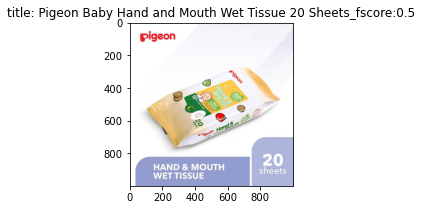

train_2427672763


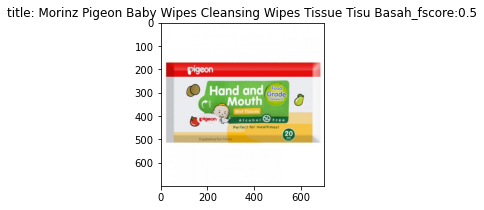

train_3681087630


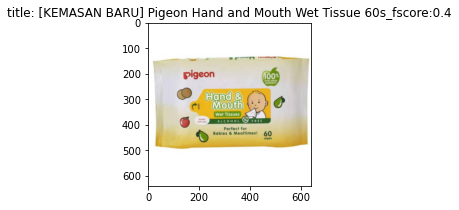

In [227]:

images = df_final[df_final["posting_id"] == "train_3681087630"]["pred"].iloc[0]
for image in images:
    print(image)
    w_df = df[df["posting_id"] == image]
    plt.figure(figsize=(3, 3))
    img = Image.open(f"../input/shopee-product-matching/train_images/{w_df['image'].values[i]}")
    plt.imshow(img)
    plt.title(f"title: {w_df['title'].values[i]}_fscore:{w_df['f1_pred'].values[i]}")
    plt.show()


In [ ]:
df[""]